
<a id='aiyagari'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# The Aiyagari Model

## Contents

- [The Aiyagari Model](#The-Aiyagari-Model)  
  - [Overview](#Overview)  
  - [The Economy](#The-Economy)  
  - [Firms](#Firms)  
  - [Code](#Code)  

## Overview

In this lecture we describe the structure of a class of models that build on work by Truman Bewley [[Bew77]](../zreferences.html#bewley1977).

We begin by discussing an example of a Bewley model due to <a href=/_static/pdfs/aiyagari_obit.pdf download>Rao Aiyagari</a>.

The model features

- Heterogeneous agents.  
- A single exogenous vehicle for borrowing and lending.  
- Limits on amounts individual agents may borrow.  


The Aiyagari model has been used to investigate many topics, including

- precautionary savings and the effect of liquidity constraints [[Aiy94]](../zreferences.html#aiyagari1994)  
- risk sharing and asset pricing [[HL96]](../zreferences.html#heaton1996)  
- the shape of the wealth distribution [[BBZ15]](../zreferences.html#benhabib2015)  
- etc., etc., etc.  

### References

The primary reference for this lecture is [[Aiy94]](../zreferences.html#aiyagari1994).

A textbook treatment is available in chapter 18 of [[LS18]](../zreferences.html#ljungqvist2012).

A continuous time version of the model by SeHyoun Ahn and Benjamin Moll can be found [here](http://nbviewer.jupyter.org/github/QuantEcon/QuantEcon.notebooks/blob/master/aiyagari_continuous_time.ipynb).

## The Economy

### Households

Infinitely lived households / consumers face idiosyncratic income shocks.

A unit interval of  *ex ante* identical households face a common borrowing constraint.

The savings problem faced by a typical  household is

$$
\max \mathbb E \sum_{t=0}^{\infty} \beta^t u(c_t)
$$

subject to

$$
a_{t+1} + c_t \leq w z_t + (1 + r) a_t
\quad
c_t \geq 0,
\quad \text{and} \quad
a_t \geq -B
$$

where

- $ c_t $ is current consumption  
- $ a_t $ is assets  
- $ z_t $ is an exogenous component of labor income capturing stochastic unemployment risk, etc.  
- $ w $ is a wage rate  
- $ r $ is a net interest rate  
- $ B $ is the maximum amount that the agent is allowed to borrow  


The exogenous process $ \{z_t\} $ follows a finite state Markov chain with given stochastic matrix $ P $.

The wage and interest rate are fixed over time.

In this simple version of the model, households supply labor  inelastically because they do not value leisure.

## Firms

Firms produce output by hiring capital and labor.

Firms act competitively and face constant returns to scale.

Since returns to scale are constant the number of firms does not matter.

Hence we can consider a single (but nonetheless competitive) representative firm.

The firm’s output is

$$
Y_t = A K_t^{\alpha} N^{1 - \alpha}
$$

where

- $ A $ and $ \alpha $ are parameters with $ A > 0 $ and $ \alpha \in (0, 1) $  
- $ K_t $ is aggregate capital  
- $ N $ is total labor supply (which is constant in this simple version of the model)  


The firm’s problem is

$$
max_{K, N} \left\{ A K_t^{\alpha} N^{1 - \alpha} - (r + \delta) K - w N \right\}
$$

The parameter $ \delta $ is the depreciation rate.

From the first-order condition with respect to capital, the firm’s inverse demand for capital is


<a id='equation-aiy-rgk'></a>
$$
r = A \alpha  \left( \frac{N}{K} \right)^{1 - \alpha} - \delta \tag{1}
$$

Using this expression and the firm’s first-order condition for labor, we can pin down
the equilibrium wage rate as a function of $ r $ as


<a id='equation-aiy-wgr'></a>
$$
w(r) = A  (1 - \alpha)  (A \alpha / (r + \delta))^{\alpha / (1 - \alpha)} \tag{2}
$$

### Equilibrium

We construct  a *stationary rational expectations equilibrium* (SREE).

In such an equilibrium

- prices induce behavior that generates aggregate quantities consistent with the prices  
- aggregate quantities and prices are constant over time  


In more detail, an SREE lists a set of prices, savings and production policies such that

- households want to choose the specified savings policies taking the prices as given  
- firms maximize profits taking the same prices as given  
- the resulting aggregate quantities are consistent with the prices; in particular, the demand for capital equals the supply  
- aggregate quantities (defined as cross-sectional averages) are constant  


In practice, once parameter values are set, we can check for an SREE by the following steps

1. pick a proposed quantity $ K $ for aggregate capital  
1. determine corresponding prices, with interest rate $ r $ determined by [(1)](#equation-aiy-rgk) and a wage rate $ w(r) $ as given in [(2)](#equation-aiy-wgr)  
1. determine the common optimal savings policy of the households given these prices  
1. compute aggregate capital as the mean of steady state capital given this savings policy  


If this final quantity agrees with $ K $ then we have a SREE.

## Code

Let’s look at how we might compute such an equilibrium in practice.

To solve the household’s dynamic programming problem we’ll use the [DiscreteDP](https://github.com/QuantEcon/QuantEcon.jl/blob/master/src/markov/ddp.jl) type from [QuantEcon.jl](http://quantecon.org/quantecon-jl).

Our first task is the least exciting one: write code that maps parameters for a household problem into the `R` and `Q` matrices needed to generate an instance of `DiscreteDP`.

Below is a piece of boilerplate code that does just this.

In reading the code, the following information will be helpful

- `R` needs to be a matrix where `R[s, a]` is the reward at state `s` under action `a`.  
- `Q` needs to be a three dimensional array where `Q[s, a, s']` is the probability of transitioning to state `s'` when the current state is `s` and the current action is `a`.  


(For a detailed discussion of `DiscreteDP` see [this lecture](../dynamic_programming/discrete_dp.html))

Here we take the state to be $ s_t := (a_t, z_t) $, where $ a_t $ is assets and $ z_t $ is the shock.

The action is the choice of next period asset level $ a_{t+1} $.

The object also includes a default set of parameters that we’ll adopt unless otherwise specified.

### Setup

In [1]:
using InstantiateFromURL
# optionally add arguments to force installation: instantiate = true, precompile = true
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.7.0")

In [2]:
using LinearAlgebra, Statistics

In [3]:
using Parameters, Plots, QuantEcon
gr(fmt = :png);

In [4]:
Household = @with_kw (r = 0.01,
                      w = 1.0,
                      σ = 1.0,
                      β = 0.96,
                      z_chain = MarkovChain([0.9 0.1; 0.1 0.9], [0.1; 1.0]),
                      a_min = 1e-10,
                      a_max = 18.0,
                      a_size = 200,
                      a_vals = range(a_min, a_max, length = a_size),
                      z_size = length(z_chain.state_values),
                      n = a_size * z_size,
                      s_vals = gridmake(a_vals, z_chain.state_values),
                      s_i_vals = gridmake(1:a_size, 1:z_size),
                      u = σ == 1 ? x -> log(x) : x -> (x^(1 - σ) - 1) / (1 - σ),
                      R = setup_R!(fill(-Inf, n, a_size), a_vals, s_vals, r, w, u),
                      # -Inf is the utility of dying (0 consumption)
                      Q = setup_Q!(zeros(n, a_size, n), s_i_vals, z_chain))

function setup_Q!(Q, s_i_vals, z_chain)
    for next_s_i in 1:size(Q, 3)
        for a_i in 1:size(Q, 2)
            for s_i in 1:size(Q, 1)
                z_i = s_i_vals[s_i, 2]
                next_z_i = s_i_vals[next_s_i, 2]
                next_a_i = s_i_vals[next_s_i, 1]
                if next_a_i == a_i
                    Q[s_i, a_i, next_s_i] = z_chain.p[z_i, next_z_i]
                end
            end
        end
    end
    return Q
end

function setup_R!(R, a_vals, s_vals, r, w, u)
    for new_a_i in 1:size(R, 2)
        a_new = a_vals[new_a_i]
        for s_i in 1:size(R, 1)
            a = s_vals[s_i, 1]
            z = s_vals[s_i, 2]
            c = w * z + (1 + r) * a - a_new
            if c > 0
                R[s_i, new_a_i] = u(c)
            end
        end
    end
    return R
end

setup_R! (generic function with 1 method)

As a first example of what we can do, let’s compute and plot an optimal accumulation policy at fixed prices

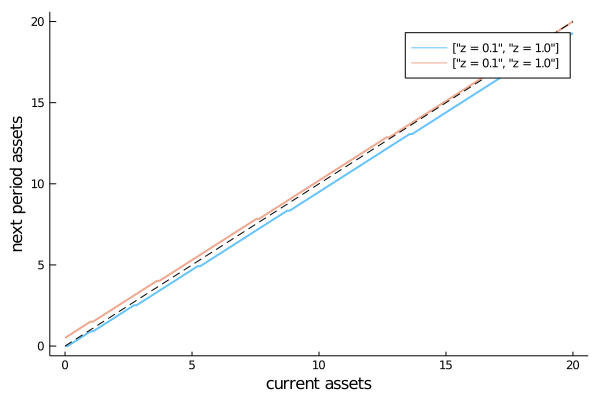

In [5]:
# Create an instance of Household
am = Household(a_max = 20.0, r = 0.03, w = 0.956)

# Use the instance to build a discrete dynamic program
am_ddp = DiscreteDP(am.R, am.Q, am.β)

# Solve using policy function iteration
results = solve(am_ddp, PFI)

# Simplify names
@unpack z_size, a_size, n, a_vals = am
z_vals = am.z_chain.state_values

# Get all optimal actions across the set of
# a indices with z fixed in each column
a_star = reshape([a_vals[results.sigma[s_i]] for s_i in 1:n], a_size, z_size)

labels = ["z = $(z_vals[1])", "z = $(z_vals[2])"]
plot(a_vals, a_star, label = labels, lw = 2, alpha = 0.6)
plot!(a_vals, a_vals, label = "", color = :black, linestyle = :dash)
plot!(xlabel = "current assets", ylabel = "next period assets", grid = false)

The plot shows asset accumulation policies at different values of the exogenous state.

Now we want to calculate the equilibrium.

Let’s do this visually as a first pass.

The following code draws aggregate supply and demand curves.

The intersection gives equilibrium interest rates and capital

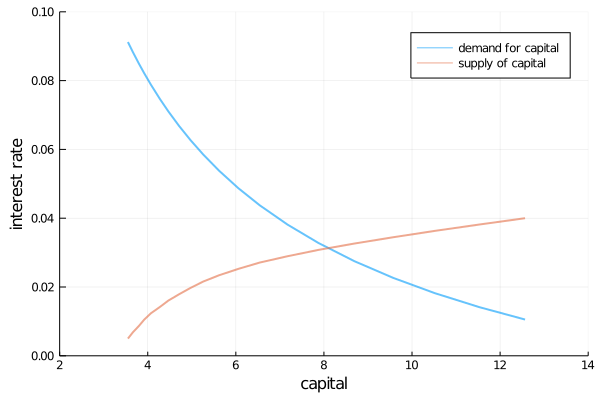

In [6]:
# Firms' parameters
const A = 1
const N = 1
const α = 0.33
const β = 0.96
const δ = 0.05

function r_to_w(r)
    return A * (1 - α) * (A * α / (r + δ)) ^ (α / (1 - α))
end

function rd(K)
    return A * α * (N / K) ^ (1 - α) - δ
end

function prices_to_capital_stock(am, r)

    # Set up problem
    w = r_to_w(r)
    @unpack a_vals, s_vals, u = am
    setup_R!(am.R, a_vals, s_vals, r, w, u)

    aiyagari_ddp = DiscreteDP(am.R, am.Q, am.β)

    # Compute the optimal policy
    results = solve(aiyagari_ddp, PFI)

    # Compute the stationary distribution
    stationary_probs = stationary_distributions(results.mc)[:, 1][1]

    # Return K
    return dot(am.s_vals[:, 1], stationary_probs)
end

# Create an instance of Household
am = Household(β = β, a_max = 20.0)

# Create a grid of r values at which to compute demand and supply of capital
r_vals = range(0.005, 0.04, length = 20)

# Compute supply of capital
k_vals = prices_to_capital_stock.(Ref(am), r_vals)

# Plot against demand for capital by firms
demand = rd.(k_vals)
labels =  ["demand for capital" "supply of capital"]
plot(k_vals, [demand r_vals], label = labels, lw = 2, alpha = 0.6)
plot!(xlabel = "capital", ylabel = "interest rate", xlim = (2, 14), ylim = (0.0, 0.1))